# 缠论编程实现

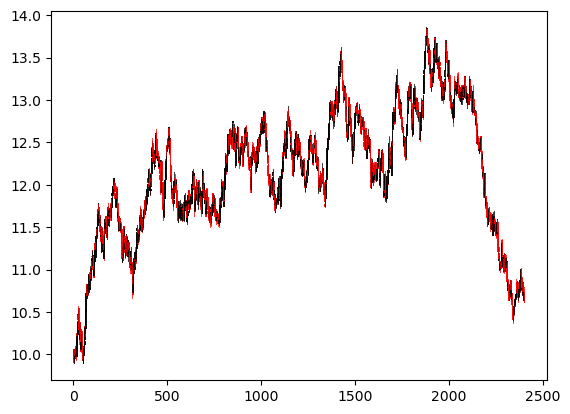

In [12]:
# 随机生成 1min KLine 作例子

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc,candlestick2_ohlc
from matplotlib.patches import Rectangle

N = 2400
px = (1+ np.cumsum(np.random.normal(0, 0.0015, 20 * N))) * 10
px = pd.Series(px)
opn = px.groupby(px.index // 20).first()
cls = px.groupby(px.index // 20).last()
hgh = px.groupby(px.index // 20).max()
low = px.groupby(px.index // 20).min()
ids = pd.Series(opn.index)
ts = pd.Series([datetime(2010,1,1) + i*timedelta(minutes=1) for i in range(N)])


df_kline = pd.concat([ids.rename('id'), ts.rename('time'), opn.rename('open'), hgh.rename('high'), low.rename('low'), cls.rename('close')], axis=1)

# plot
fig,ax = plt.subplots()
_ = candlestick2_ohlc(ax, df_kline.open, df_kline.high, df_kline.low, df_kline.close)

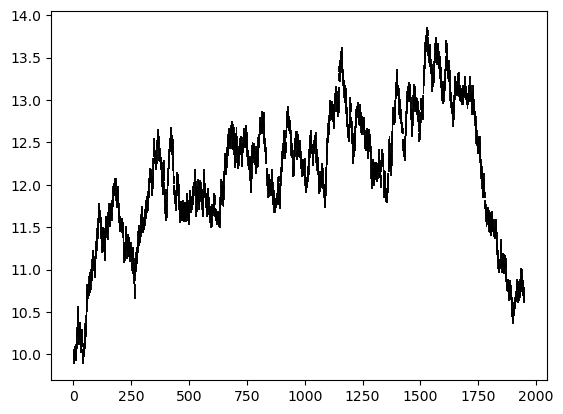

In [14]:
#%% 缠论 K 线

n = len(df_kline)

cklines = []

for i in range(n):
    id,t,low,hgh = df_kline.iloc[i][['id','time','low','high']]
    if len(cklines) == 0:
        cklines.append((id,t,low,hgh))
    elif len(cklines) == 1:
        pid, pt, plow, phgh = cklines[-1]
        if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh):
            cklines[-1] = (id,t, max(plow,low), max(phgh, hgh))
        else:
            cklines.append((id,t,low,hgh))
    else:
        pid, pt, plow, phgh = cklines[-1]
        if cklines[-1][2] > cklines[-2][2]: # up
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # up-up merge
                cklines[-1] = (id, t, max(plow,low), max(phgh, hgh))
            else:
                cklines.append((id, t, low, hgh))
 
        else: # down
            if (low<=plow and hgh>=phgh) or (plow<=low and phgh>=hgh): # low-low merge
                cklines[-1] = (id, t, min(plow,low), min(phgh, hgh))
            else:
                cklines.append((id, t, low, hgh))

# 缠论 K 线
df_ckline = pd.DataFrame(data=cklines, columns=['id','time','low','high'])



# plot
fig,ax = plt.subplots()
_ = candlestick2_ohlc(ax, df_ckline.low, df_ckline.high, df_ckline.low, df_ckline.high)

In [16]:
#%% 顶/底分型

parts = []
for i in range(1, len(df_ckline)-1):
    pid, pt, plow, phgh = df_ckline.iloc[i-1][['id','time', 'low','high']]
    id, t, low, hgh = df_ckline.iloc[i][['id','time','low','high']]
    nlow, nhgh = df_ckline.iloc[i+1][['low','high']]

    if i == 1: # 对于第0个元素，只看第1个元素跟其关系（当然也可以直接舍弃）
        if hgh > phgh:
            parts.append((-1, pid, pt, plow, phgh))
        else:
            parts.append((1, pid, pt, plow, phgh))

    if hgh > phgh and hgh > nhgh: # 顶分型
        parts.append((1,id, t,low,hgh))
    elif hgh < phgh and hgh < nhgh: # 底分型
        parts.append((-1,id, t,low,hgh))

df_part = pd.DataFrame(data=parts, columns=('type','id','time','low','high'))
df_part


,type,id,time,low,high
0,1,0,2010-01-01 00:00:00,9.995490,10.058688
1,-1,4,2010-01-01 00:04:00,9.892486,9.978109
2,1,6,2010-01-01 00:06:00,9.992799,10.063712
3,-1,7,2010-01-01 00:07:00,9.990589,10.053926
4,1,8,2010-01-01 00:08:00,9.998367,10.098466
...,...,...,...,...,...
842,1,2381,2010-01-02 15:41:00,10.954636,11.024266
843,-1,2389,2010-01-02 15:49:00,10.705156,10.769596
844,1,2391,2010-01-02 15:51:00,10.750738,10.881804
845,-1,2395,2010-01-02 15:55:00,10.640432,10.716795


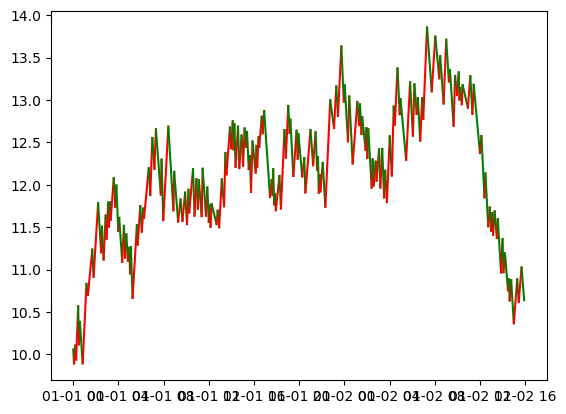

,di,id0,id1,t0,t1,px0,px1
0,-1,0,4,2010-01-01 00:00:00,2010-01-01 00:04:00,10.058688,9.892486
1,1,4,11,2010-01-01 00:04:00,2010-01-01 00:11:00,9.892486,10.103568
2,-1,11,15,2010-01-01 00:11:00,2010-01-01 00:15:00,10.103568,9.939129
3,1,15,26,2010-01-01 00:15:00,2010-01-01 00:26:00,9.939129,10.565393
4,-1,26,30,2010-01-01 00:26:00,2010-01-01 00:30:00,10.565393,10.118469
...,...,...,...,...,...,...,...
222,-1,2326,2340,2010-01-02 14:46:00,2010-01-02 15:00:00,10.873446,10.367068
223,1,2340,2358,2010-01-02 15:00:00,2010-01-02 15:18:00,10.367068,10.884328
224,-1,2358,2366,2010-01-02 15:18:00,2010-01-02 15:26:00,10.884328,10.619579
225,1,2366,2381,2010-01-02 15:26:00,2010-01-02 15:41:00,10.619579,11.024266


In [17]:
#%% 笔

biparts = []
for i in range(len(parts)):
    typ, id, t, low, hgh = parts[i]
    if len(biparts) == 0:
        biparts.append(parts[i])
    else:
        ptyp, pid, pt, plow, phgh = biparts[-1]

        if (ptyp != typ) and (id-pid >= 4):
            biparts.append(parts[i])

        elif (ptyp == typ == 1) and (hgh >= phgh):
            biparts[-1] = parts[i]

        elif (ptyp == typ == -1) and (low <= plow):
            biparts[-1] = parts[i]


bis = []
for i in range(1, len(biparts)):
    typ0, id0, t0, low0, hgh0 = biparts[i-1]
    typ1, id1, t1, low1, hgh1 = biparts[i]

    px0 = low0 if typ0 == -1 else hgh0 
    px1 = low1 if typ1 == -1 else hgh1

    # 方向，1：向上，-1：向下
    di = 1 if px1 > px0 else -1
    
    bis.append((di, id0, id1, t0, t1, px0, px1))

# 笔
df_bi = pd.DataFrame(data=bis, columns=['di', 'id0','id1','t0','t1','px0','px1'])


# plot
fig,ax = plt.subplots()
#_ = candlestick_ohlc(ax, df_ckline.values)

for di,id0,id1,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],color=['','r','g'][int(di)])
plt.show()

df_bi


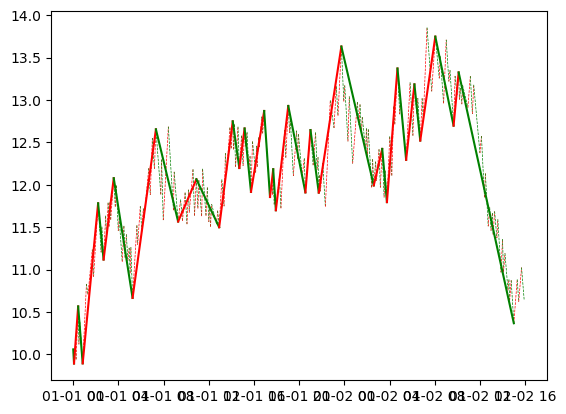

,di,id0,id1,t0,t1,px0,px1
0,-1,0,4,2010-01-01 00:00:00,2010-01-01 00:04:00,10.058688,9.892486
1,1,4,26,2010-01-01 00:04:00,2010-01-01 00:26:00,9.892486,10.565393
2,-1,26,50,2010-01-01 00:26:00,2010-01-01 00:50:00,10.565393,9.893877
3,1,50,132,2010-01-01 00:50:00,2010-01-01 02:12:00,9.893877,11.781342
4,-1,132,161,2010-01-01 02:12:00,2010-01-01 02:41:00,11.781342,11.118405
5,1,161,215,2010-01-01 02:41:00,2010-01-01 03:35:00,11.118405,12.077672
6,-1,215,315,2010-01-01 03:35:00,2010-01-01 05:15:00,12.077672,10.665897
7,1,315,439,2010-01-01 05:15:00,2010-01-01 07:19:00,10.665897,12.654088
8,-1,439,557,2010-01-01 07:19:00,2010-01-01 09:17:00,12.654088,11.566322
9,1,557,654,2010-01-01 09:17:00,2010-01-01 10:54:00,11.566322,12.065274


In [18]:
#%% 线段

segs = []

bis = df_bi.copy()
is_head = True

while len(bis) > 3:
    # B：序列开始位置
    if is_head:
        # 第1笔向上
        if bis.iloc[0].di == 1:

            s1,x1,s2,x2 = bis.iloc[0],bis.iloc[1],bis.iloc[2],bis.iloc[3]

            # B1-1: s1 作为第1段
            # B2-1: s1 作为第1段
            if (
                (s2.px1 < s1.px0) 
                or 
                (s2.px1 < s1.px1) 
            ):
                segs.append(tuple(s1))
                bis = bis.iloc[1:]


            # B3-1: x1,x2...寻找顶分型
            # B4-1: x1,x2...寻找顶分型
            elif (
                ((s2.px1 > s1.px1) and (x2.px1 < x1.px1)) 
                or 
                ((s2.px1 > s1.px1) and (x2.px1 > x1.px1)) 
            ):
                found = False
                plow,phgh = x2.px1,x2.px0
                for i in range(5,len(bis),2):
                    di,id0,id1,t0,t1,hgh,low = bis.iloc[i]

                    # 找到顶分型
                    if hgh < phgh and low < plow:
                        s_b, s_e = s1, bis.iloc[i-3] # 线段 开始/结尾 的向上笔
                        segs.append((1, s_b.id0, s_e.id1,s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                        
                        bis = bis.iloc[i-2:]
                        found = True

                        break
                    plow,phgh = max(plow,low),max(phgh,hgh)

                # 未找到底分型，结束
                if not found:
                    break

                is_head = False
            
            else: 
                raise Exception("some error")


        # 第1笔向下
        else: 
            x1,s1,x2,s2 = bis.iloc[0],bis.iloc[1],bis.iloc[2],bis.iloc[3]

            # B1-2: x1 作为第1段
            # B2-2: x1 作为第1段
            if (
                (x2.px1 > x1.px0) 
                or 
                (x2.px1 > x1.px1) 
            ):
                segs.append(tuple(x1))
                bis = bis.iloc[1:]


            # B3-2: s1,s2...寻找底分型
            # B4-2: s1,s2...寻找底分型
            elif (
                ((x2.px1 < x1.px1) and (s2.px1 > s1.px1)) 
                or 
                ((x2.px1 < x1.px1) and (s2.px1 < s1.px1)) 
            ):
                found = False
                plow,phgh = s2.px0,s2.px1
                for i in range(5,len(bis),2):
                    di,id0,id1,t0,t1,low,hgh = bis.iloc[i]

                    # 找到底分型
                    if low > plow and hgh > phgh:
                        s_b, s_e = x1, bis.iloc[i-3] # 线段 开始/结尾 的向下笔
                        segs.append((-1, s_b.id0, s_e.id1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                        
                        bis = bis.iloc[i-2:]
                        found = True

                        break
                    plow,phgh = min(plow,low),min(phgh,hgh)

                # 未找到底分型，结束
                if not found:
                    break

                is_head = False
            
            else: 
                raise Exception("some error")



    # A: 序列中间位置
    else:
        # 第1笔向上，x1,x2,...中寻找顶分型

        if bis.iloc[0].di == 1:
            s1,x1,s2 = bis.iloc[0],bis.iloc[1],bis.iloc[2]

            found = False
            plow,phgh = x1.px1,x1.px0
            for i in range(3,len(bis),2):
                di,id0,id1,t0,t1,hgh,low = bis.iloc[i]

                # 找到顶分型
                if hgh < phgh and low < plow:
                    s_b, s_e = s1, bis.iloc[i-3] # 线段 开始/结尾 的向上笔
                    segs.append((1, s_b.id0, s_e.id1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                    
                    bis = bis.iloc[i-2:]
                    found = True

                    break
                plow,phgh = max(plow,low),max(phgh,hgh)

            # 未找到顶分型，结束
            if not found:
                break


        # 第1笔向下，s1,s2,...中寻找底分型
        else:
            x1,s1,x2 = bis.iloc[0],bis.iloc[1],bis.iloc[2]

            found = False
            plow,phgh = s1.px0,s1.px1
            for i in range(3,len(bis),2):
                di,id0,id1,t0,t1,low,hgh = bis.iloc[i]

                # 找到底分型
                if low > plow and hgh > phgh:
                    s_b, s_e = x1, bis.iloc[i-3] # 线段 开始/结尾 的向下笔
                    segs.append((-1, s_b.id0, s_e.id1, s_b.t0, s_e.t1, s_b.px0, s_e.px1))
                    
                    bis = bis.iloc[i-2:]
                    found = True

                    break
                plow,phgh = min(plow,low),min(phgh,hgh)

            # 未找到底分型，结束
            if not found:
                break



# 线段
df_seg = pd.DataFrame(data=segs, columns=['di','id0','id1','t0','t1','px0','px1'])


# plot
fig,ax = plt.subplots()
#_ = candlestick_ohlc(ax, df_ckline.values)

# plot 笔
for di,id0,id1,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],'--',color=['','r','g'][int(di)], linewidth=0.5)

# plot 线段
for di,id0,id1,t0,t1,px0,px1 in df_seg.values:
    _ = ax.plot([t0,t1],[px0,px1],color=['','r','g'][int(di)], linewidth=1.5)

plt.show()

df_seg

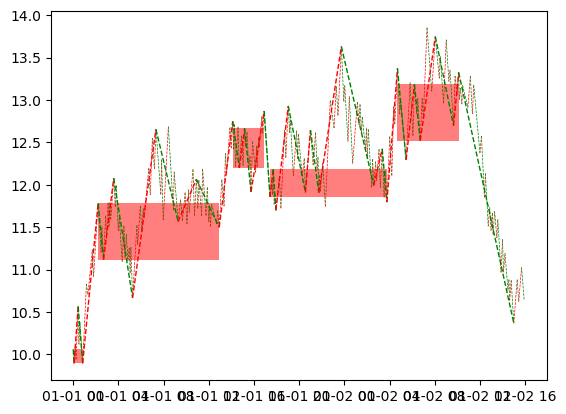

,di,level,bgn_id,end_id,dd,gg,zd,zg
0,-1.0,1.0,0.0,3.0,9.892486,10.565393,9.893877,10.058688
1,-1.0,1.0,3.0,11.0,10.665897,12.654088,11.118405,11.781342
2,-1.0,1.0,11.0,16.0,11.916803,12.870312,12.198008,12.664268
3,1.0,1.0,16.0,27.0,11.699678,13.630715,11.856118,12.183310
4,-1.0,1.0,27.0,34.0,12.294836,13.747630,12.521681,13.184239


In [19]:
#%% 
# 中枢画法1: 不考虑中枢升级，只画中枢，用不同时间的K线做不同等级
# 比如1min K线画的中枢就是1min，5min 画的就是5min 

class ZS:
    def __init__(self,bgn_id, end_id, 
                 di, level, 
                 dd,gg,zd,zg):
        # 次级别中枢进入(开始)，出去(结束)的id
        self.bgn_id, self.end_id = bgn_id,end_id

        # 中枢参数
        self.dd,self.gg,self.zd,self.zg = dd,gg,zd,zg

        # 中枢方向，即中枢特征序列方向，与进入方向相反
        self.di = di

        # 中枢级别
        self.level = level

        self.merge_count = 1


    def to_series(self):
        ds = pd.Series(data=[self.di, self.level, 
                             self.bgn_id, self.end_id, 
                        self.dd, self.gg, self.zd, self.zg,], 
                index=['di', 'level',
                       'bgn_id','end_id',
                       'dd','gg','zd','zg',])

        return ds
    
    def __str__(self):
        return str(self.to_series())


zss = []


for i in range(len(df_seg)):
    sid = i
    di,id0,id1,t0,t1,px0,px1 = df_seg.iloc[i]
    low,hgh = min(px0,px1),max(px0,px1)

    # 第一个线段，独自作为一个中枢
    if i == 0:
        zs = ZS(sid,sid,di,1,low,hgh,low,hgh)
        zss.append(zs)

    else:
        zs = zss[-1]

        if (low > zs.zg or hgh < zs.zd):
            zs = ZS(sid-1,sid,di,1,low,hgh,low,hgh)
            zss.append(zs)

        else:
            # last end segment
            end_di, end_id0, end_id1, end_t0, end_t1, end_px0, end_px1 = df_seg.iloc[zs.end_id]
            end_low, end_hgh = min(end_px0,end_px1), max(end_px0,end_px1)

            zs.dd = min(zs.dd, end_low)
            zs.gg = max(zs.gg, end_hgh)

            zs.end_id = sid
            if sid - zs.bgn_id == 3:
                zs.zd = max(zs.zd, low)
                zs.zg = min(zs.zg, hgh)
              

# 中枢 ['di','bgn_sid','end_sid,'dd','gg','zd','zg','level','merge_count']
df_zs = pd.concat(map(lambda zs:zs.to_series(),zss),axis=1).T



# plot
fig,ax = plt.subplots()
#_ = candlestick_ohlc(ax, df_ckline.values)

# plot 笔
for di,id0,id1,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],'--',color=['','r','g'][int(di)], linewidth=0.5, alpha=1)

# plot 线段
for di,id0,id1,t0,t1,px0,px1 in df_seg.values:
    _ = ax.plot([t0,t1],[px0,px1],'--',color=['','r','g'][int(di)], linewidth=1, alpha=1)

# plot 中枢
level_colors = ['','red','orange','y','g','b']
for di,level,bgn_id,end_id,dd,gg,zd,zg in df_zs.values:
    t0 = df_seg.loc[bgn_id].t1
    t1 = df_seg.loc[end_id].t0
    ax.add_patch(Rectangle((t0, dd), t1-t0, gg-dd, facecolor=level_colors[int(level)], alpha=0.))
    ax.add_patch(Rectangle((t0, zd), t1-t0, zg-zd, facecolor=level_colors[int(level)], alpha=0.5))

    

plt.show()

df_zs







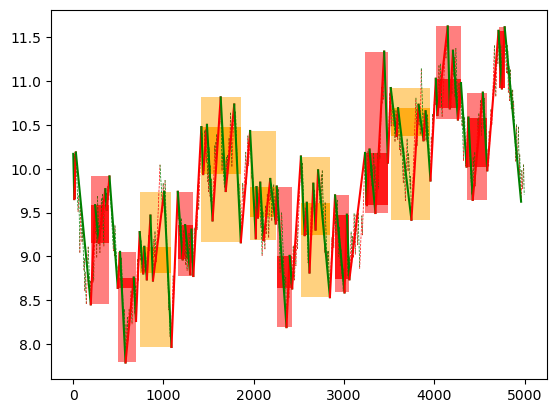

,di,bgn_sid,end_sid,dd,gg,zd,zg,level,merge_count
0,-1.0,0.0,2.0,9.653741,10.185268,9.653741,10.168926,1.0,1.0
1,1.0,2.0,8.0,8.453885,9.911244,9.155726,9.584022,1.0,1.0
2,1.0,8.0,13.0,7.790775,9.050842,8.641577,8.758596,1.0,1.0
3,-1.0,13.0,21.0,7.967814,9.736237,8.806273,9.108945,2.0,1.0
4,-1.0,21.0,27.0,8.776888,9.736475,8.966383,9.356491,1.0,1.0
5,-1.0,27.0,35.0,9.161434,10.813301,9.938987,10.473854,2.0,1.0
6,-1.0,35.0,43.0,9.184552,10.429702,9.443745,9.790744,2.0,1.0
7,-1.0,43.0,47.0,8.194211,9.796372,8.635130,9.005860,1.0,1.0
8,-1.0,47.0,55.0,8.535707,10.138430,9.242976,9.611305,2.0,1.0
9,-1.0,55.0,59.0,8.589259,9.695387,8.739109,9.475334,1.0,1.0


In [347]:
# 中枢

class ZS:
    def __init__(self,bgn_sid, end_sid, di, dd,gg,zd,zg):
        self.bgn_sid, self.end_sid = bgn_sid,end_sid
        self.dd,self.gg,self.zd,self.zg = dd,gg,zd,zg

        # 中枢方向，即中枢特征序列方向，与进入方向相反
        self.di = di
        self.level = 1

        # 当前中枢扩展了几个同级别中枢，如果>=3个，中枢升级
        self.merge_count = 1

    def to_series(self):
        ds = pd.Series(data=[self.di, self.bgn_sid, self.end_sid, 
                        self.dd, self.gg, self.zd, self.zg,
                        self.level, self.merge_count,], 
                index=['di','bgn_sid','end_sid',
                       'dd','gg','zd','zg',
                       'level','merge_count',])

        return ds
    
    def __str__(self):
        return str(self.to_series())


zss = []


for i in range(len(df_seg)):
    sid = i
    di,t0,t1,px0,px1 = df_seg.iloc[i]
    low,hgh = min(px0,px1),max(px0,px1)

    # 第一个线段，独自作为一个中枢
    if i == 0:
        zs = ZS(sid,sid,di,low,hgh,low,hgh)
        zss.append(zs)

    else:
        zs = zss[-1]

        if zs.level != 1:
            zs = ZS(sid-1,sid,di,low,hgh,low,hgh)
            zss.append(zs)

        else:
            if low > zs.zg or hgh < zs.zd:
                zs = ZS(sid-1,sid,di,low,hgh,low,hgh)
                zss.append(zs)

            else:
                # last end segment
                end_di, end_t0, end_t1, end_px0, end_px1 = df_seg.iloc[zs.end_sid]
                end_low, end_hgh = min(end_px0,end_px1), max(end_px0,end_px1)

                zs.dd = min(zs.dd, end_low)
                zs.gg = max(zs.gg, end_hgh)

                zs.end_sid = sid
                if sid - zs.bgn_sid == 3:
                    zs.zd = max(zs.zd, low)
                    zs.zg = min(zs.zg, hgh)

                # 中枢延伸升级
                if sid - zs.bgn_sid + 1 >= 9:
                    zs.level += 1




    # 最大中枢 level
    max_level = 1
    
    # 中枢扩展，最大扩展到 max_level      
    def zs_expand(max_level=max_level):            
        zs = zss[-1]
        zss.pop()
        i = len(zss)-1
        while i >= 0 and zs.level < max_level and zss[-1].level <= zs.level:
            if zss[-1].level < zs.level:
                i -= 1
            else:
                zs1 = zss[-1]
                if zs1.dd > zs.gg or zs1.gg < zs.dd:
                    break
                zs.zd,zs.zg = max(zs.dd, zs1.dd),min(zs.gg, zs1.gg)
                zs.dd,zs.gg = min(zs.dd, zs1.dd),max(zs.gg, zs1.gg)
                zs.bgn_sid = zs1.bgn_sid

                zs.merge_count += 1
                # 中枢升级
                if zs.merge_count % 3 == 0:
                    zs.level += 1
                
                for j in range(i,len(zss)):
                    zss.pop()
                i -= 1
        zss.append(zs)

        

    # 次级别走势升级为高级别中枢，最大升级到 max_level
    def zs_upgrade(max_level=max_level):        
        zs = zss[-1]
        if zs.level >= max_level:
            return False
        
        i = len(zss)-1
        neighbor_same_level_ids = []
        while i >= 0 and zss[i].level <= zs.level:
            if zss[i].level == zs.level:
                neighbor_same_level_ids.append(i)
            i -= 1

        if len(neighbor_same_level_ids) < 3:
            return False
        

        n = len(neighbor_same_level_ids)
        ss = [0 for _ in range(n)]
        for i in range(1,n):
            id_i, id_j = neighbor_same_level_ids[i], neighbor_same_level_ids[i-1]
            zs_i, zs_j = zss[id_i],zss[id_j]
            if zs_i.zg > zs_j.zg:
                ss[i] = 1
            else:
                ss[i] = -1

        print(ss)


    #zs_expand() 
    #zs_upgrade()






                

# 中枢 ['di','bgn_sid','end_sid,'dd','gg','zd','zg','level','merge_count']
df_zs = pd.concat(map(lambda zs:zs.to_series(),zss),axis=1).T



# plot
fig,ax = plt.subplots()
#_ = candlestick_ohlc(ax, df_ckline.values)

# plot 笔
for di,t0,t1,px0,px1 in df_bi.values:
    _ = ax.plot([t0,t1],[px0,px1],'--',color=['','r','g'][int(di)], linewidth=0.5)

# plot 线段
for di,t0,t1,px0,px1 in df_seg.values:
    _ = ax.plot([t0,t1],[px0,px1],color=['','r','g'][int(di)], linewidth=1.5)

# plot 中枢
level_colors = ['','r','orange','y','g','b']
for di,bgn_sid,end_sid,dd,gg,zd,zg,level,merge_count in df_zs.values:
    t0 = df_seg.loc[bgn_sid].t1
    t1 = df_seg.loc[end_sid].t0
    ax.add_patch(Rectangle((t0, dd), t1-t0, gg-dd, facecolor=level_colors[int(level)], alpha=0.5))
    ax.add_patch(Rectangle((t0, zd), t1-t0, zg-zd, facecolor=level_colors[int(level)], alpha=0.8))

    

plt.show()

df_zs

